# Procuring OOI Data for John Wilkin
Concise notebook of datastream methods for retrieving and cleaning up OOI data: surface-piercing profiler's spectral irradiance. Set up to run on OOI kernel jupyter-lab (jupyter.oceanobservatories.org).

author: Turner E Johnson

date: 2023-09-14

defunct: Jan 5 2023. see new one.

In [1]:
#package installation cell: from Ian Black OSU
%matplotlib inline

import importlib
import subprocess
import sys
import os
packages = ['seaborn','imageio','xarray','prettytable','tqdm']  

for package in packages:
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, '-m' ,'pip','install',package])

In [11]:
#package import cell
%matplotlib inline

import csv
import io
import numpy as np
import os
import pandas as pd
import re
import sys
import time
import xarray as xr
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import warnings

from ooi_data_explorations.common import get_vocabulary, list_deployments,load_kdata, N_CORES, FILL_INT
from ooi_data_explorations.uncabled.process_optaa import optaa_cspp
from ooi_data_explorations.uncabled.process_spkir import spkir_cspp
from ooi_data_explorations.profilers import create_profile_id, bin_profiles

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from tqdm import tqdm
from scipy import stats
#from prettytable import PrettyTable

### Manual, one at a time way:
Each surface-piercing profiler (at 4 sites) has ~30 deployments which each need to be loaded individually. I load these .nc files into xarray Datasets, which maintains metadata. I'm using Chris Wingard's function load_kdata from his ooi_data_explorations package, which tunnels into data directories located on the same server as this JupyterLab. It is much faster than THREDDS/URL loading.

In [3]:
# SPKIR (spectral irradiance) request params
site = 'CE02SHSP'           # OOI Net site designator: Oregon Shelf
node = 'SP001'              # OOI Net node designator
sensor = '06-SPKIRJ000'     # OOI Net sensor designator: Spectral Irradiometer
stream = 'spkir_abj_cspp_instrument_recovered'  # OOI Net stream name
method = 'recovered_cspp'   # OOI Net data delivery method
level = 'profiler'              # local directory name, level below site
instrmt = 'spkir'           # local directory name, instrument below level

deploy = 2 # specify deployment here
vocab = get_vocabulary(site, node, sensor)[0]

# load data from the local kdata directory (on kernel)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))

#turner put rest of tut here

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


In [4]:
# functions for automating!!

#spkir_load_deployments: loads all deployments into a dictionary of datasets.
# returns dictionary of datasets and dataframe of summary data.
def spkir_load_deployments(site= 'CE02SHSP',node= 'SP001',sensor= '06-SPKIRJ000'):
    deployments_count = max(list_deployments(site, node, sensor))
    spkir_dict = {}
    for deploy in range(1, deployments_count+1): 
        var_name = f"spkir{deploy}"   
        stream = 'spkir_abj_cspp_instrument_recovered' 
        method = 'recovered_cspp'
        level = 'profiler'
        instrmt = 'spkir'
        vocab = get_vocabulary(site, node, sensor)[0]
        dataset = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy)) #requires ooinet connection
        spkir_dict[var_name] = dataset
    valid_keys = []
    len_1 = []
    len_2 = []
    for name,ds in list(spkir_dict.items()):
        if ds is not None:
            valid_keys.append(name)
            len_1.append(len(ds.time))
            ds = spkir_cspp(ds)
            ds = create_profile_id(ds)
            vocab = get_vocabulary(ds.attrs['subsite'],ds.attrs['node'], ds.attrs['sensor'])[0]
            site_depth = vocab['maxdepth'] -2
            profiles = ds.groupby('profile')
            profiles = [profile[1] for profile in profiles]
            partial_binning = partial(bin_profiles, site_depth=site_depth, bin_size=0.5)

            with ProcessPoolExecutor(max_workers=N_CORES) as executor:
                binned = list(tqdm(executor.map(partial_binning, profiles), total=len(profiles),
                               desc='{}: smoothing and binning each profile into 0.5m depth bins'.format(name), file=sys.stdout))
            binned = [i[0] for i in binned if i is not None]
            binned = xr.concat(binned, 'time')
            ds = binned.sortby(['profile', 'time'])
            ds['depth'] = -ds['depth']
            len_2.append(len(ds.time))
            spkir_dict[name] = ds
        else:
            print("Invalid dataset:",name,"has no data.")

    summary_df = pd.DataFrame({'deployment': valid_keys,
                               'initial_length': len_1,
                               'binned_length': len_2})
    return [spkir_dict, summary_df]

def spkir_contempCal(spkir_dict):
    #:: adds 7 contemp cal variables to each profile in the deployment ds.
    #:: input spkir dictionary 
    #:: returns updated spkir dictionary.
    dw_E_list = ["downwelling_irradiance_412", "downwelling_irradiance_444",
             "downwelling_irradiance_490","downwelling_irradiance_510",
             "downwelling_irradiance_555","downwelling_irradiance_620",
             "downwelling_irradiance_683"]
    calContemp_E_list = ["cal_E_412_C","cal_E_444_C","cal_E_490_C","cal_E_510_C","cal_E_555_C","cal_E_620_C","cal_E_683_C"]
    for name,ds in list(spkir_dict.items()):
        if ds is not None:
            for var in calContemp_E_list:
                ds[var] = ds.downwelling_irradiance_412 * 100 #dummy variables to to be repopulated

            for p in range(1, int(max(ds.profile.values)) + 1): #profiles start at 1 and end at true number: needs +1
                profile = ds.where(ds.profile == p, drop=True) #select profile by p_number
                if profile is not None and len(profile.time) != 0: #skip profile if it is empty.
                    for band, cal_var in zip(dw_E_list, calContemp_E_list): #toss out profile if bad band
                        cal_data = profile[band] - np.min(profile[band].values) + np.spacing(1)
                        ds[cal_var].loc[ds.profile == p] = cal_data
                else: print("Bad profile",p,"in",name) #means length of profile is 0 :(
            spkir_dict[name] = ds
            print("{} now has {} variables!".format(name,len(ds)))
        else:
            print("Invalid dataset:",name,"has no data.")
    return spkir_dict

def plot_depth_profiles(dictionary, deploy, pnum, band_list,title_descriptor):
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
    pal = sns.color_palette(colors)

    Kd_list = ["Kd_412","Kd_444","Kd_490","Kd_510","Kd_555","Kd_620","Kd_683"]
    Kd_intercept_list = ["Kd_412_intcpt","Kd_444_intcpt","Kd_490_intcpt","Kd_510_intcpt","Kd_555_intcpt","Kd_620_intcpt","Kd_683_intcpt"]


    grouped_deploy = dictionary[deploy].groupby('profile')
    profile = grouped_deploy[pnum]
    
    fig,ax = plt.subplots(1,2,figsize=(7,5),dpi=300)
    for i,band in enumerate(band_list):
        lbl = re.findall(r'\d+', band)
        ax[0].plot(profile[band], profile.depth,color = pal[i],alpha=0.6,label = lbl,linewidth = .8)
        ax[1].plot(np.log(profile[band]),profile.depth,color=pal[i],alpha=0.6,label=lbl)
        
        #if Kd var exists: plot it on log plot.
        Kd_name = Kd_list[i]
        Kd_int_name = Kd_intercept_list[i]
        if Kd_name and Kd_name in profile.data_vars: #not plotting when Kd is NaN
            Kd = profile[Kd_name].values[0]
            intrcpt = profile[Kd_int_name].values[0]
            print(Kd, intrcpt)
            E_array = np.log(np.unique(profile[band].values))
            ax[1].plot(E_array, Kd*E_array+intrcpt, label=Kd_name,color = pal[i],linestyle="--",linewidth=.8)
        else:
            print("No Kd data!")

    ax[0].set_ylabel("depth (m)")
    ax[0].set_xlabel("spectral irradiance E (uW cm-2 nm-1)")
    ax[1].set_xlabel("Log(E) (uW cm-2 nm-1)")
    ax[0].set_title("Spectral Irradiance")
    ax[1].set_title("Log of Spectral Irradiance")

    ax[0].legend(fontsize=7)
    ax[1].legend(fontsize=7)
    fig.suptitle("{} depth profile {} in deployment {}".format(title_descriptor,pnum,deploy), y=1)
    plt.show()
    
def plot_Kds(dictionary, deploy):
    colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
    pal = sns.color_palette(colors)
    
    ds = dictionary[deploy]
    fig,ax = plt.subplots(figsize=(6,4),dpi=300)
    for i,band in enumerate(Kd_list):
        ax.plot(ds.profile, ds[band], color = pal[i],label = band)

    ax.set_ylabel("Kd")
    ax.set_xlabel("profile")
    ax.set_title("Diffuse Attenuation Coefficient Kd by profile for deployment {}".format(deploy),fontsize=9)

    ax.legend(fontsize=7)
    plt.show()

Calling functions one at a time to act on a dictionary object full of all deployments for the site. This first function,spkir_load_deployments, takes the longest to run.

In [5]:
spkir_dict,summary_df = spkir_load_deployments(site= 'CE02SHSP',node= 'SP001',sensor= '06-SPKIRJ000')

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:00<00:00, 13.17it/s]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


Loading and Processing Data Files: 0it [00:00, ?it/s]
/home/jovyan/code/ooi-data-explorations/python/ooi_data_explorations/common.py:856: UserWarning: No data files were loaded from the JupyterHub kdata directory.
  warnings.warn(message)


spkir1: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 47/47 [00:02<00:00, 17.55it/s]
spkir2: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 102/102 [00:05<00:00, 17.17it/s]
spkir3: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 101/101 [00:04<00:00, 21.75it/s]
spkir4: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 78/78 [00:04<00:00, 18.68it/s]
spkir5: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 38/38 [00:02<00:00, 17.05it/s]
spkir6: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 15/15 [00:00<00:00, 16.66it/s]
spkir7: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 103/103 [00:06<00:00, 16.06it/s]
spkir8: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 43/43 [00:02<00:00, 15.13it/s]
spkir9: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 41/41 [0

The next function, spkir_contempCal, creates 7 new variables, one for each λ of spectral irradiance, calibrated to zero their minimum value + translate everything else up/down. This function has a pretty short runtime.

In [6]:
spkir_dict2 = spkir_contempCal(spkir_dict)

spkir1 now has 33 variables!
spkir2 now has 33 variables!
spkir3 now has 33 variables!
spkir4 now has 33 variables!
spkir5 now has 33 variables!
spkir6 now has 33 variables!
spkir7 now has 33 variables!
spkir8 now has 33 variables!
spkir9 now has 33 variables!
spkir10 now has 33 variables!
spkir11 now has 33 variables!
spkir12 now has 33 variables!
spkir13 now has 33 variables!
spkir14 now has 33 variables!
spkir15 now has 33 variables!
spkir16 now has 33 variables!
spkir17 now has 33 variables!
spkir18 now has 33 variables!
spkir19 now has 33 variables!
spkir20 now has 33 variables!
spkir21 now has 33 variables!
Bad profile 11 in spkir22
Bad profile 31 in spkir22
spkir22 now has 33 variables!
spkir23 now has 33 variables!
spkir24 now has 33 variables!
spkir25 now has 33 variables!
spkir26 now has 33 variables!
spkir27 now has 33 variables!
spkir28 now has 33 variables!
spkir29 now has 33 variables!
spkir30 now has 33 variables!
spkir31 now has 33 variables!
spkir32 now has 33 variable

In [1]:
def spkir_nightCal(spkir_dict,summary_df):
    #:: adds 7 night cal variables to each profile in the deployment ds.
    #:: input spkir dictionary, summary df
    #:: returns updated spkir noons dictionary and updated summary df

    #mute log(0) warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    spkirNoons_dict = {}
    spkirNoons_dict_grouped = {}
    len3 = [] #empty list for recording new lengths for summary_df
    
    displayLog = True
    handPickNoonProfiles = False
    showAllPlots = False
    
    z30m_array = np.arange(-30, -1, 0.5)
    z30m_data_array = xr.DataArray(z30m_array, dims='depth30m', coords={'depth30m': z30m_array})

    
    dw_E_list = ["downwelling_irradiance_412", "downwelling_irradiance_444",
             "downwelling_irradiance_490","downwelling_irradiance_510",
             "downwelling_irradiance_555","downwelling_irradiance_620",
             "downwelling_irradiance_683"]
    dw_E_labels = ["412nm raw", "444nm raw","490nm raw","510nm raw","555nm raw","620nm raw","683nm raw"]
    calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]
    calNight_E_labels = ["412nm cal ","444nm cal","490nm cal","510nm cal","555nm cal","620nm cal","683nm cal"]
    Kd_list = ["Kd_412","Kd_444","Kd_490","Kd_510","Kd_555","Kd_620","Kd_683"]
    Kd_intercept_list = ["Kd_412_intcpt","Kd_444_intcpt","Kd_490_intcpt","Kd_510_intcpt","Kd_555_intcpt","Kd_620_intcpt","Kd_683_intcpt"]
    Kd_list30mfit = ["Kd_412_30mfit","Kd_444_30mfit","Kd_490_30mfit","Kd_510_30mfit","Kd_555_30mfit","Kd_620_30mfit","Kd_683_30mfit"]
    #Kd_intercept_list30mfit = ["Kd_412_intcpt_30mfit","Kd_444_intcpt_30mfit","Kd_490_intcpt_30mfit","Kd_510_intcpt_30mfit","Kd_555_intcpt_30mfit","Kd_620_intcpt_30mfit","Kd_683_intcpt_30mfit"]
    # obs

    
    colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
    pal = sns.color_palette(colors)
    noon_start_hour,noon_end_hour = 16, 22 #UTC
    
    for name, ds in list(spkir_dict.items()):
        if ds is not None:   

            ds.coords['depth30m'] = z30m_data_array
            for i,band in enumerate(calNight_E_list): #initialising calNight_E_list var labels w/ dummy values.
                ds[band] = ds.downwelling_irradiance_683 * 100000 
                #and also initializing Kd variables here too.
                #Kd_var = Kd_list[i]
                #ds[Kd_var] = ds.downwelling_irradiance_555 * 10000
                Kd_var30 = Kd_list30mfit[i]
                ds[Kd_var30] = z30m_data_array*1000
                
            #-- determining noon-time profiles within deployment ds ---------------------------------------------
            ds_noons = ds.where((ds.time.dt.hour >= noon_start_hour) & (ds.time.dt.hour <= noon_end_hour),drop=True)
            noon_profile_nums = np.unique(ds_noons.profile)
            #ds['noon_profiles'] = ds.profile*1000 #dummy to repopulate #new method reuses var "profile"
            
            if handPickNoonProfiles: #notdebugged DEV!!!!!!!!!!!!!!!!!!!!!!
                profile_colors = plt.cm.tab20b(np.linspace(0, 1, len(noon_profile_nums)))
                plt.figure(figsize=(10, 6),dpi=180)  
                for profile, color in zip(noon_profile_nums, profile_colors):
                    mask_hpk = ds_noons['profile'] == profile
                    plt.scatter(ds_noons['time'][mask_hpk],ds_noons['depth'][mask_hpk],s=3,c=[color],label=f'profile {profile}')
                legend_marker_size = 60
                handler_map = {tuple: HandlerTuple(ndivide=None)}
                scatter_legend = plt.legend(handler_map=handler_map,loc='center left',bbox_to_anchor=(1, 0.5))
                for handle in scatter_legend.legend_handles:
                    handle.set_sizes([legend_marker_size])
                plt.title("{} noon profiles in deployment {}".format(len(np.unique(ds_noons.profile)),name))
                plt.show()
                user_input = input("Profiles to delete for deployment {} (space-separated integers): ".format(name))
                profiles_to_drop = [int(x) for x in user_input.split()]
                print("Dropping profile(s):",profiles_to_drop,"if in noons list.")
                for bad_profile in profiles_to_drop:
                    ds_noons = ds_noons.where(ds_noons.profile != bad_profile, drop=True)
            
            #-- determining nearby night-time profiles, within /pm 10 casts for every nooncast ---------------------------
            night_start_hour,night_end_hour = 4,11 #UTC
            len_before_drops = len(ds_noons.time)
            
            #initialise empty ds_noons_cal.
            ds_noons_cal = None
            
            #in each deployment, cycle through all noon profiles. tqdm package makes wait bars.
            for noon_pnum in tqdm(noon_profile_nums,desc = "Calculating nightCals for {}".format(name)):
                #pulling out noon_cast as subset of dataset ds. will concat calibrated profiles into a new ds, ds_noons_cal.
                noon_cast = ds.where(ds.profile == noon_pnum, drop=True) #should just be profile of ds_noons?
                #noon_cast['noon_profiles'] = np.full(len(noon_cast.noon_profiles), noon_pnum) #diff method of doing this just reuses var "profile"
                nearby_night_casts = ds.where(
                    (ds.profile >= noon_pnum - 10) & (ds.profile <= noon_pnum + 10) &
                    (ds.time.dt.hour >= night_start_hour) & (ds.time.dt.hour <= night_end_hour), drop=True)
                
                if len(np.unique(nearby_night_casts.profile)) == 0:
                    if displayLog:
                        print("Invalid profile",noon_pnum,". No night casts within ± 10 profiles; without cal values the selected noon profile is being deleted.")
                    ds_noons = ds_noons.where(ds_noons.profile != noon_pnum, drop=True) #eliminating profile.
                else:
                    if displayLog:
                        print("for profile",noon_pnum,"there are",np.unique(nearby_night_casts.profile),"as near night casts")
                    
                    #---- from list of nearby_night_casts, calculating closest cast to selected noon cast -----------------------
                    smallest_time_delta = float("inf")
                    closest_profile = None

                    for profile_num in np.unique(nearby_night_casts.profile):
                        current_profile_data = ds.where(ds.profile == profile_num, drop=True)
                        current_profile_datetime = current_profile_data.time[0].values
                        noon_cast_datetime = noon_cast.time[0].values
                        time_diff_seconds = abs(np.timedelta64(current_profile_datetime - noon_cast_datetime).astype('timedelta64[s]').astype(float))
                        if time_diff_seconds < smallest_time_delta:
                            smallest_time_delta = time_diff_seconds
                            closest_profile = profile_num

                    night_cast = ds.where(ds.profile == closest_profile,drop=True)
                    night_mins=[]

                    for band in dw_E_list:
                        min_value = np.min(night_cast[band].values)
                        night_mins.append(min_value)

                    
                    #now using night_mins from closest_profile, we are calibrating the noon_cast and adding it to a new ds, ds_noons_cal
                    # most important part of the function o.o
                    for i, band in enumerate(dw_E_list):
                        print(noon_cast.coords.keys())
                        cal_data = xr.DataArray(
                            noon_cast[band].data - night_mins[i] + np.spacing(1),
                            coords=noon_cast[band].coords,
                            dims=noon_cast[band].dims
                        )
                        print("turner caldaat",cal_data.coords.keys())
                        noon_cast[calNight_E_list[i]] = cal_data
                        print("LEN DIFF NOONCAST, CALDATA",len(noon_cast[band])-len(cal_data))

                        print("cal_data has",len(cal_data.values[cal_data.values < 0]),"neg values. want 0.")
                        
                        
                        #------- calculating Kd of top 30m: depth*slope + intercept of log fit -------
                        #z30m_array = np.arange(-30, -1, 0.5)
                        #noon_cast.coords['depth30m'] = z30m_array #setting these depths as a coordinate: for plotting.
                        
                        noon_cast30 = noon_cast.where(noon_cast['depth'].isin(z30m_array), drop=True) #subselecting data from noon_cast ds
                        
                        print("LEN DIFF 30m ARRAY", len(z30m_array)-len(noon_cast30.depth.values)) #want this to be 0
                        
                        if len(z30m_array)-len(noon_cast30.depth.values) > 0:
                            #break loop. do not add noon_cast to ds_noons_cal.
                            cal_data = np.full(len(cal_data),np.nan) #dev PROBLEM that caldata is reassigned before this. maybe do after
                            #adjust from ? ds_noons = ds_noons.where(ds_noons.profile != noon_pnum, drop=True)
                        
                        else: #proceed as normal
                            #depth_array_30 = noon_cast30.depth.values
                            #recalculating the depth-subselected cals.
                            cal_data30 = noon_cast30[band] - night_mins[i] + np.spacing(1)
                            print(cal_data30)
                            log_spkr_array30 = np.log(cal_data30)
                            print("nooncast len",len(z30m_array))
                            print("logspkir:",len(log_spkr_array30))
                            slope30, intercept30, r_value30, p_value30, std_err30 = stats.linregress(z30m_array, log_spkr_array30)
                            fit_30m = slope30*z30m_array + intercept30
                            fit_30m = np.exp(fit_30m)
                            print("fit30m",fit_30m)
                            #fit30m_array = xr.DataArray(fit_30m, coords={'depth30m'})

                            #pulling out names to assign data to.
                            Kd_var30 = Kd_list30mfit[i]
                            #Kd_intrcpt30 = Kd_intercept_list30mfit[i] #make this var obsolete.
                            if np.isnan(slope30):
                                noon_cast[Kd_var30] = np.nan
                            else:
                                noon_cast[Kd_var30] = fit_30m
                        #print(noon_cast[Kd_var30])
                        
                        ######################################
                        

                    if ds_noons_cal is None:
                        ds_noons_cal = noon_cast #first profile in first deployment
                    else:
                        ds_noons_cal = xr.concat([ds_noons_cal, noon_cast], dim='time')

                    for i,band in enumerate(calNight_E_list):
                        plt.plot(noon_cast[band], noon_cast.depth, color=pal[i])
                    plt.show()
                    #concatenating profile to ds_noons_cal
                    if showAllPlots: #not debugged DEV!!!!!!!
                        profile = ds_noons.where(ds_noons.profile == noon_pnum)
                        fig,ax = plt.subplots(1,2,figsize=(9, 5),dpi=180)

                        for i,lam in enumerate(calNight_E_list):
                            ax[0].plot(noon_cast[lam], noon_cast['depth'], color = pal[i], label = calNight_E_labels[i])
                            ax[0].plot(noon_cast[dw_E_list[i]], noon_cast['depth'], color = pal[i], alpha = 0.2, label= dw_E_labels[i])
                        ax[0].set_title("Night-Calibrated spkir for profile {}".format(np.unique(noon_cast.profile)),fontsize=12)
                        ax[0].set_xlabel("spectral irradiance (Wm^-2nm^-1)")
                        ax[0].set_ylabel('depth')
                        ax[0].legend(fontsize=6)

                        for i,lam in enumerate(calNight_E_list):
                            ax[1].plot(profile[lam], profile['depth'], color = pal[i], label = calNight_E_labels[i])
                            ax[1].plot(profile[dw_E_list[i]], profile['depth'], color = pal[i], alpha = 0.2, label= dw_E_labels[i])
                        ax[1].set_title("near-zero -0.05 < E < 0.5: profile {}".format(np.unique(profile.profile)),fontsize=12)
                        ax[1].set_xlabel("spectral irradiance (Wm^-2nm^-1)")
                        ax[1].set_ylabel('depth')
                        ax[1].axvline(x=0, color='k', linestyle='--')
                        ax[1].legend(fontsize=6)
                        ax[1].set_xlim(-.05,.5)
                        plt.show()
   
            #length statistics for summary_df.
            len_after_drops = len(ds_noons_cal.time)
            len3.append(len_after_drops)
            #------ swapping "time" dimension for profile, depth. -----------
            ds_noons_cal = ds_noons_cal.assign_coords(profile=ds_noons_cal['profile'])
            ds_noons_cal = ds_noons_cal.assign_coords(depth=ds_noons_cal['depth'])
            ds_noons_cal = ds_noons_cal.swap_dims({'time': 'profile'})
            
            #------ adding the entire noons dataset to a new dictionary. ---
            spkirNoons_dict[name] = ds_noons_cal
            spkirNoons_dict_grouped[name] = ds_noons_cal.groupby('profile') #also have "grouped" dict which is better for plotting profiles
        else:
            if displayLog:
                print("Invalid dataset:",name,"has no data.")
    len3_col = pd.Series(len3, name='nightCal_noons_length')
    summary_df = pd.concat([summary_df, len3_col], axis=1)
        
    return spkirNoons_dict,spkirNoons_dict_grouped,summary_df

In [2]:
spkir1test = spkir_dict34['spkir1'].groupby("profile")
for i in range(1, len(spkir1test)+1):
    try:
        if spkir1test[i]:
            profile = spkir1test[i]
            print(profile.depth.values[-15:-1])
    except KeyError as e:
        print(f"Skipping index {i} due to KeyError: {e}")
        continue

NameError: name 'spkir_dict34' is not defined

NameError: name 'profile' is not defined

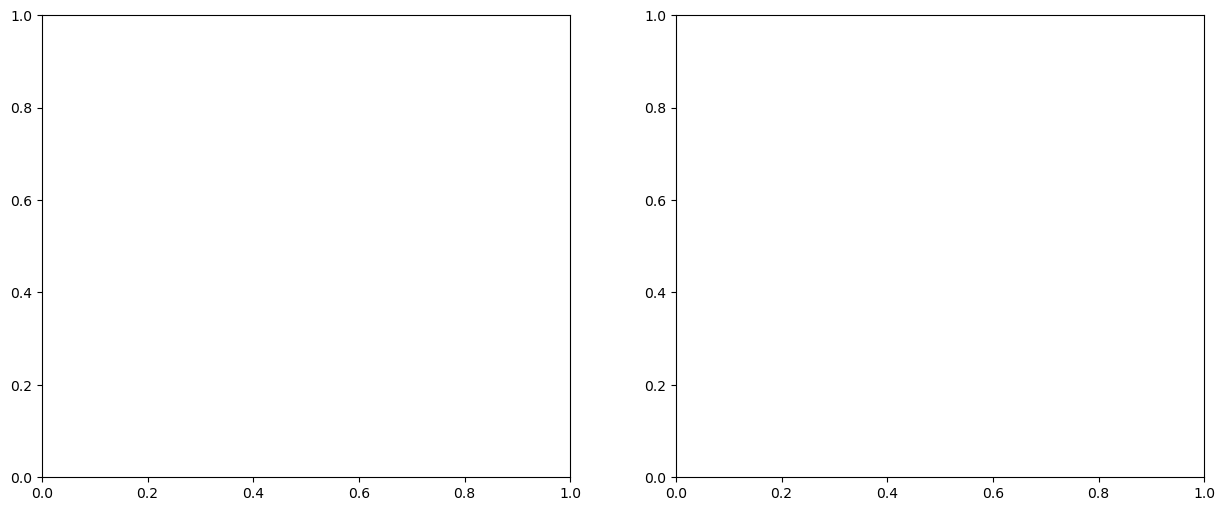

In [17]:
#test cell
import matplotlib.pyplot as plt

colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal = sns.color_palette(colors)
dw_E_list = ["downwelling_irradiance_412", "downwelling_irradiance_444",
         "downwelling_irradiance_490","downwelling_irradiance_510",
         "downwelling_irradiance_555","downwelling_irradiance_620",
         "downwelling_irradiance_683"]
Kd_list30mfit = ["Kd_412_30mfit","Kd_444_30mfit","Kd_490_30mfit","Kd_510_30mfit","Kd_555_30mfit","Kd_620_30mfit","Kd_683_30mfit"]
Kd_intercept_list30mfit = ["Kd_412_intcpt_30mfit","Kd_444_intcpt_30mfit","Kd_490_intcpt_30mfit","Kd_510_intcpt_30mfit","Kd_555_intcpt_30mfit","Kd_620_intcpt_30mfit","Kd_683_intcpt_30mfit"]
calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]



ds = spkir_dict2['spkir6']
ds = ds.groupby("profile")
#profile = ds[15]

fig, ax = plt.subplots(1,2, figsize=(15, 6))

for i, band in enumerate(dw_E_list):
    ax[0].plot(profile[band],profile.depth, label=band,color=pal[i])
ax[0].set_title("Spectral Irradiance")
ax[1].set_title("Log Spectral Irradiance")
for i,band2 in enumerate(calNight_E_list):
    ax[1].plot(np.log(profile[band2]),profile.depth,label=band2,color=pal[i])
ax[1].legend()
ax[0].legend()
plt.show()


In [13]:
spkir_dict2["spkir1"]

<xarray.Dataset>
Dimensions:                            (time: 6400, depth30m: 58)
Coordinates:
  * time                               (time) datetime64[ns] 2015-03-18T19:37...
  * depth30m                           (depth30m) float64 -30.0 -29.5 ... -1.5
Data variables: (12/47)
    lat                                (time) float64 44.64 44.64 ... 44.64
    internal_temperature               (time) float64 37.88 37.76 ... 37.94
    lon                                (time) float64 -124.3 -124.3 ... -124.3
    input_voltage                      (time) float64 8.404 8.383 ... 8.391
    seawater_pressure                  (time) float32 68.53 68.08 ... 1.072
    deployment                         (time) float64 1.0 1.0 1.0 ... 1.0 1.0
    ...                                 ...
    cal_E_555_N                        (time) float64 655.7 691.2 ... 2.069e+06
    Kd_555_30mfit                      (depth30m) float64 -3e+04 ... -1.5e+03
    cal_E_620_N                        (time) float64 655.7 691.2 ... 2.069e+06
    Kd_620_30mfit                      (depth30m) float64 -3e+04 ... -1.5e+03
    cal_E_683_N                        (time) float64 655.7 691.2 ... 2.069e+06
    Kd_683_30mfit                      (depth30m) float64 -3e+04 ... -1.5e+03
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             spkir_abj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.30043
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [29]:
spkir_dict34,spkirNoons_dict_grouped,summary_df34 = spkir_nightCal(spkir_dict2,summary_df)

Calculating nightCals for spkir1:   0%|          | 0/20 [00:00<?, ?it/s]

for profile 1.0 there are [ 8. 11.] as near night casts
KeysView(Coordinates:
  * time      (time) datetime64[ns] 2015-03-18T19:37:04.350647047 ... 2015-03...
  * depth30m  (depth30m) float64 -30.0 -29.5 -29.0 -28.5 ... -3.0 -2.5 -2.0 -1.5)
turner caldaat KeysView(Coordinates:
  * time     (time) datetime64[ns] 2015-03-18T19:37:04.350647047 ... 2015-03-...)
LEN DIFF NOONCAST, CALDATA 0
cal_data has 0 neg values. want 0.
LEN DIFF 30m ARRAY 0
<xarray.DataArray 'downwelling_irradiance_412' (time: 58)>
array([1.54336536e-02, 1.75451113e-02, 2.10869538e-02, 2.43428034e-02,
       2.30986207e-02, 2.47847828e-02, 3.23766355e-02, 4.14478956e-02,
       4.68961658e-02, 4.52567721e-02, 4.97421534e-02, 6.74906174e-02,
       8.74134267e-02, 1.06902255e-01, 1.06392130e-01, 8.86680433e-02,
       1.25289482e-01, 1.63120631e-01, 1.60685775e-01, 1.63599976e-01,
       1.92711727e-01, 2.09689394e-01, 2.42078113e-01, 3.02298511e-01,
       3.56490542e-01, 3.73324415e-01, 4.88541797e-01, 5.73631962e-01,

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'Kd_412_30mfit'}

In [15]:
summary_df

,deployment,initial_length,binned_length
0,spkir1,99727,6400
1,spkir2,214827,14674
2,spkir3,213537,11381
3,spkir4,114627,10445
4,spkir5,51516,4795
5,spkir6,22760,2214
6,spkir7,228416,15433
7,spkir8,76217,6428
8,spkir9,79033,4852
9,spkir10,39019,2678


In [ ]:
spkir=spkir_dict34['spkir5']
spkir = spkir.groupby('profile')

In [ ]:
calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]

plot_depth_profiles(spkir_dict34, 'spkir2', 6.0, calNight_E_list,'nightCal')

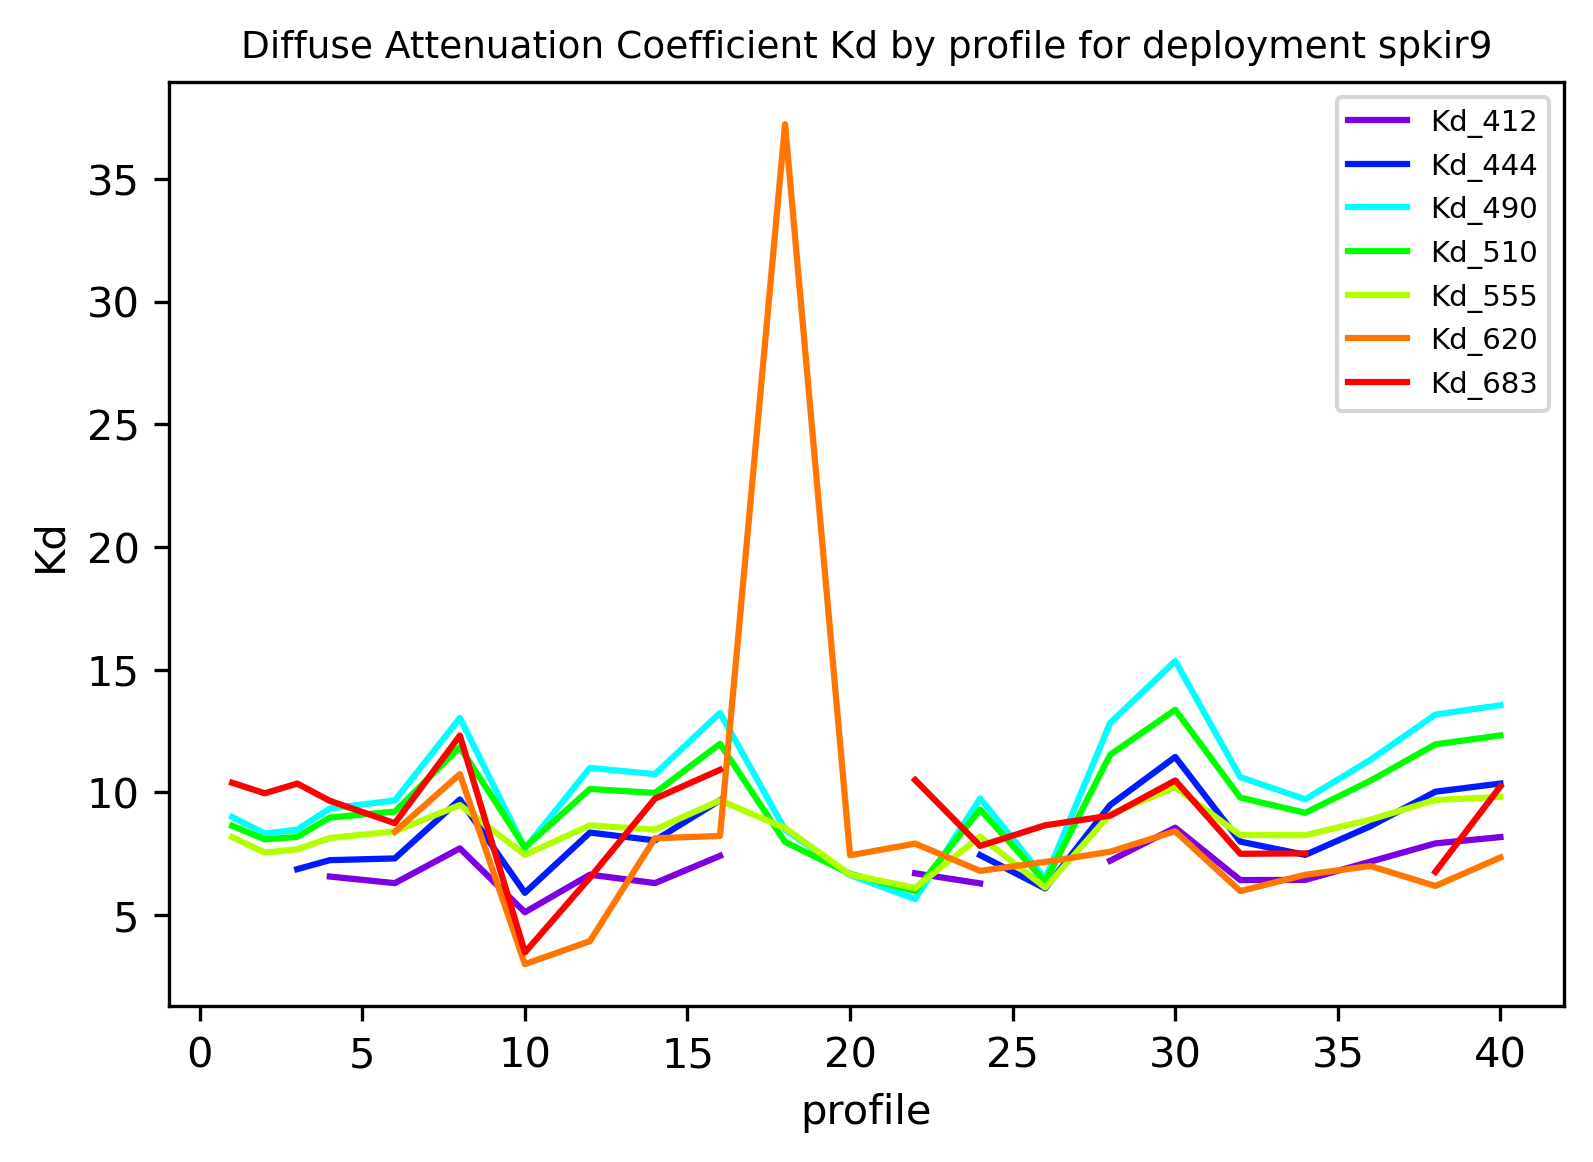

In [25]:
Kd_list = ["Kd_412","Kd_444","Kd_490","Kd_510","Kd_555","Kd_620","Kd_683"]

plot_Kds(spkir_dict34,'spkir9')

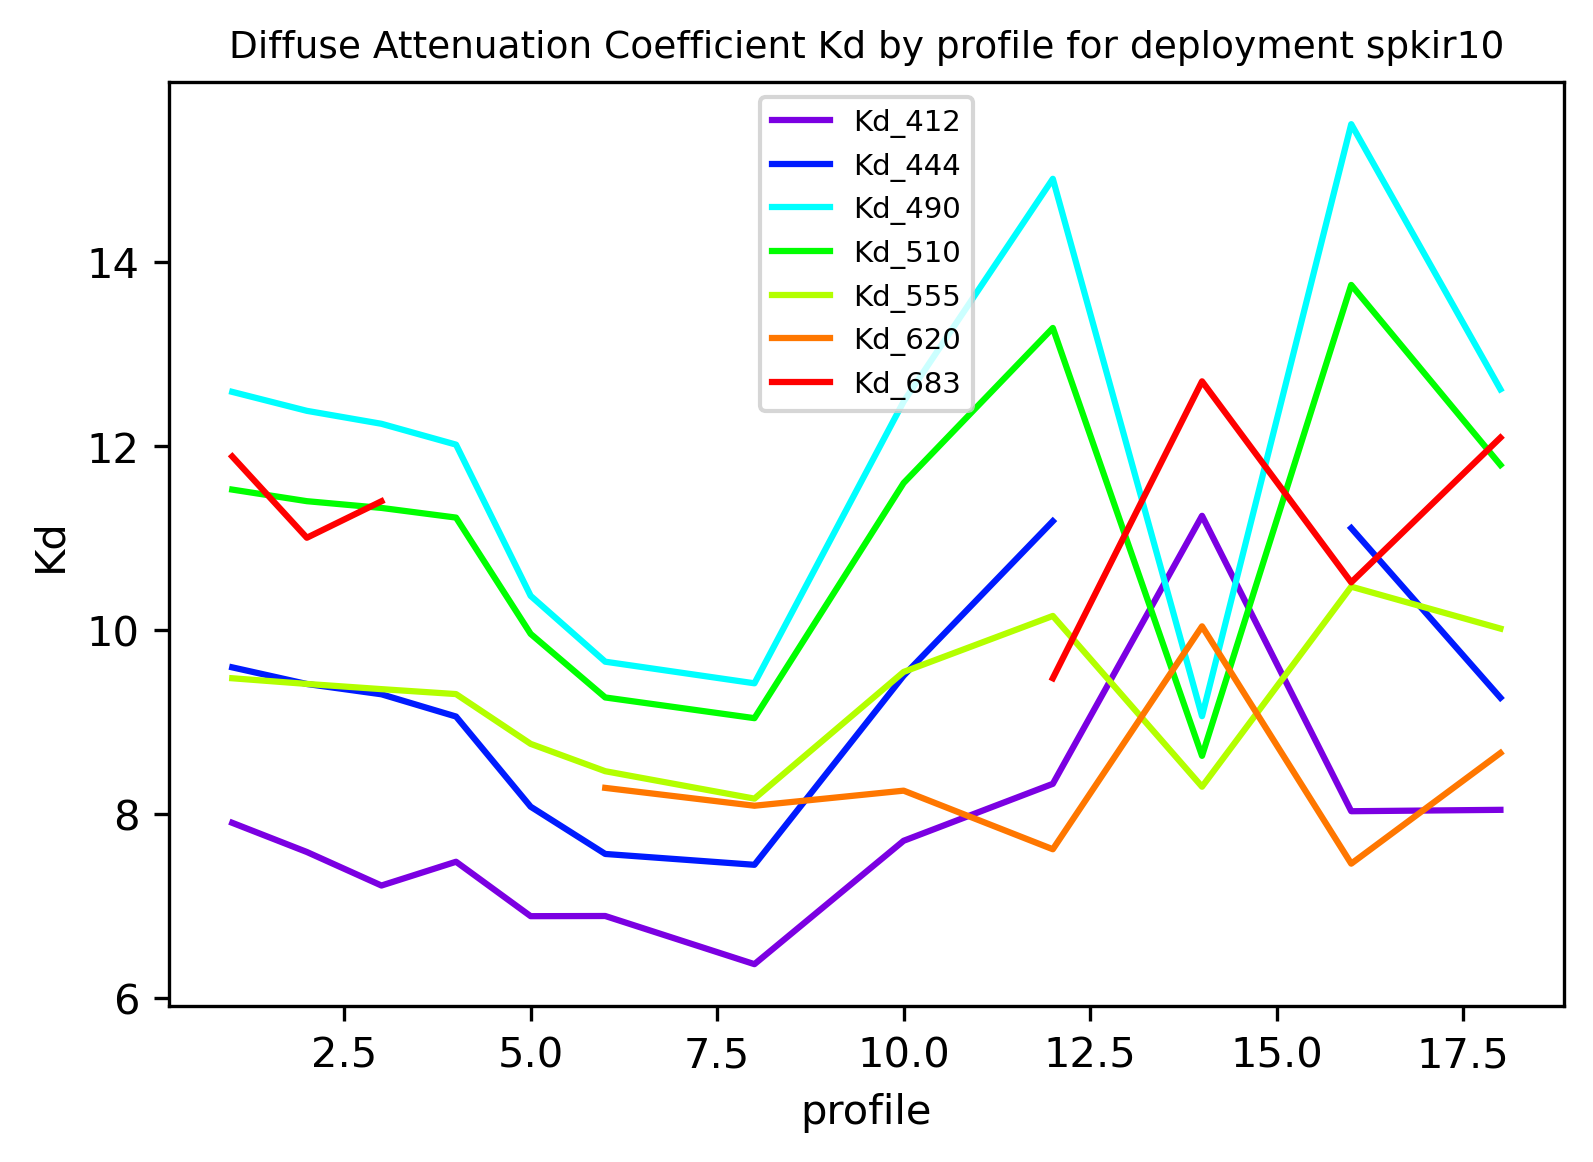

6.372588905967931 -3.5807650489114584
7.452026111927488 -3.709537559463902
9.423868896553785 -4.135261756572022
9.04507531262884 -4.237780356413835
8.171005752965012 -4.376169504392124
8.093803085945849 -0.7874278740371667
nan nan


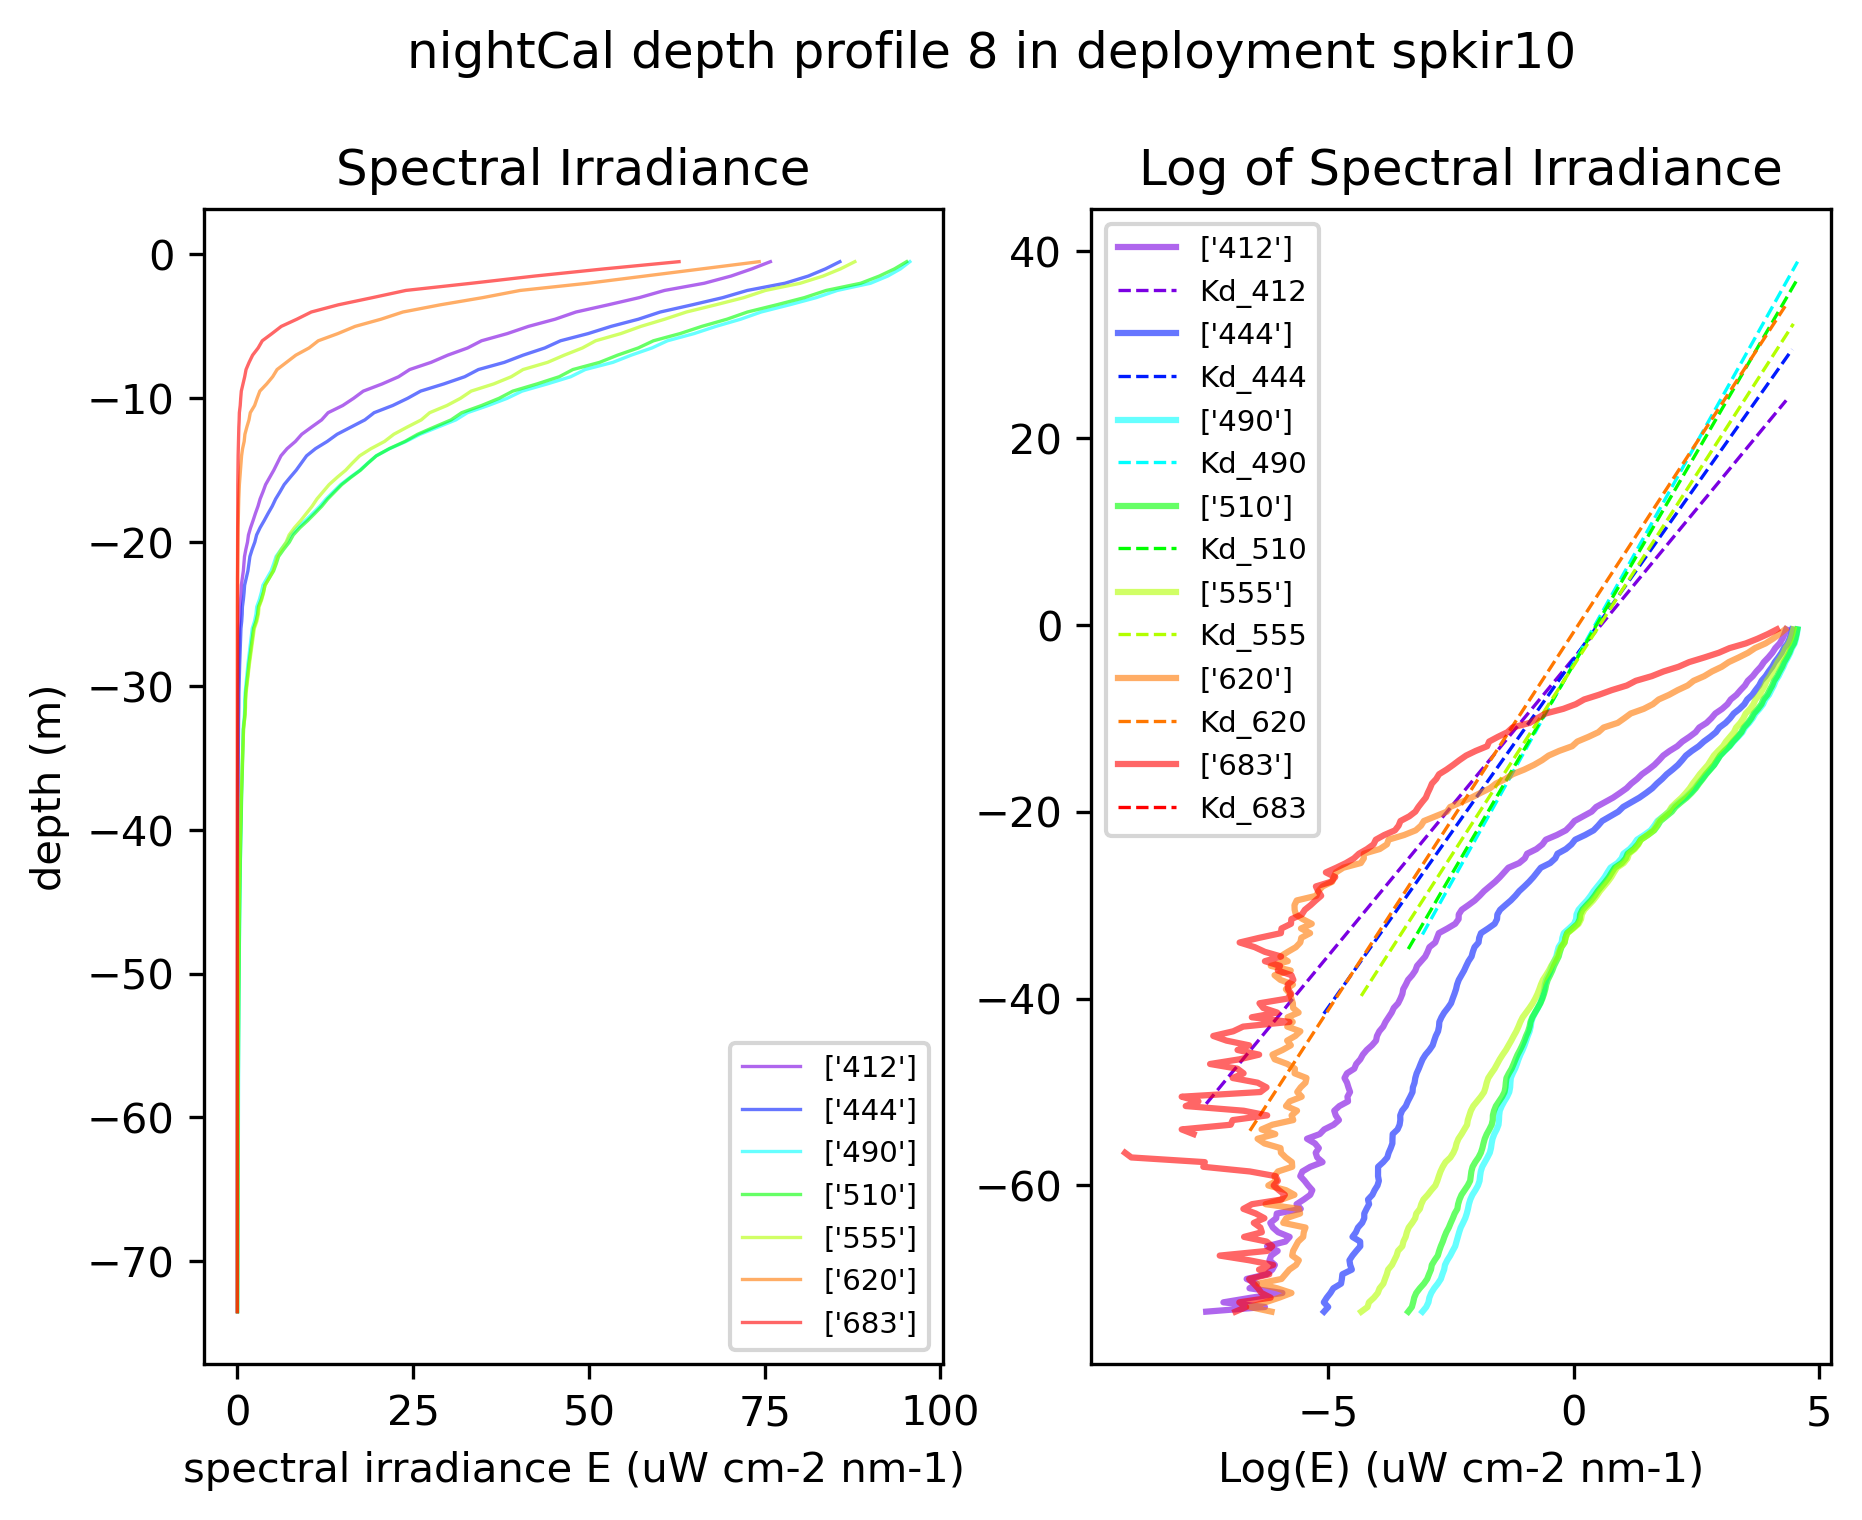

In [17]:
plot_Kds(spkir_dict34,'spkir10')
plot_depth_profiles(spkir_dict34,'spkir10',8,calNight_E_list,'nightCal')

In [18]:
spkir_dict34['spkir10']

<xarray.Dataset>
Dimensions:                            (profile: 1783)
Coordinates:
    depth                              (profile) float64 -74.5 -74.0 ... -0.5
  * profile                            (profile) float64 1.0 1.0 ... 18.0 18.0
    time                               (profile) datetime64[ns] 2018-05-23T17...
Data variables: (12/52)
    lat                                (profile) float64 44.63 44.63 ... 44.63
    internal_temperature               (profile) float64 38.87 39.0 ... 39.0
    lon                                (profile) float64 -124.3 ... -124.3
    input_voltage                      (profile) float64 8.448 8.436 ... 8.44
    seawater_pressure                  (profile) float32 74.95 74.65 ... 0.6898
    deployment                         (profile) float64 10.0 10.0 ... 10.0 10.0
    ...                                 ...
    Kd_444_intcpt                      (profile) float64 -2.958 -2.958 ... -2.13
    Kd_490_intcpt                      (profile) float64 -3.225 ... -2.853
    Kd_510_intcpt                      (profile) float64 -3.306 -3.306 ... -3.13
    Kd_555_intcpt                      (profile) float64 -3.345 ... -3.709
    Kd_620_intcpt                      (profile) float64 nan nan ... -0.3786
    Kd_683_intcpt                      (profile) float64 1.395 1.395 ... 1.478
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             spkir_abj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.29883
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down